# Uncertainty 

This is a tutorial for the uncertainty module.

In [20]:
import copy
import scipy as sp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures, Entity
from climada.hazard import Hazard
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5, ENT_DEMO_TODAY, ENT_DEMO_FUTURE

In [3]:
def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

def exp_func(x_exp, exp_base=exp_base):
    exp = copy.deepcopy(exp_base)
    exp.value *= x_exp
    exp.check()
    return exp

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

2021-02-19 21:11:17,276 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-02-19 21:11:17,318 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


## Impact 

In [4]:
exp = exp_func
exp_distr = {"x_exp": sp.stats.beta(0.8, 1.2),
              }
exp_unc = UncVar(exp, exp_distr)

impf = impf_func
impf_distr = {
    "G": sp.stats.truncnorm(0.8,1.2),
    "v_half": sp.stats.uniform(35, 100),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 5)
    }
impf_unc = UncVar(impf, impf_distr)

haz = haz_base

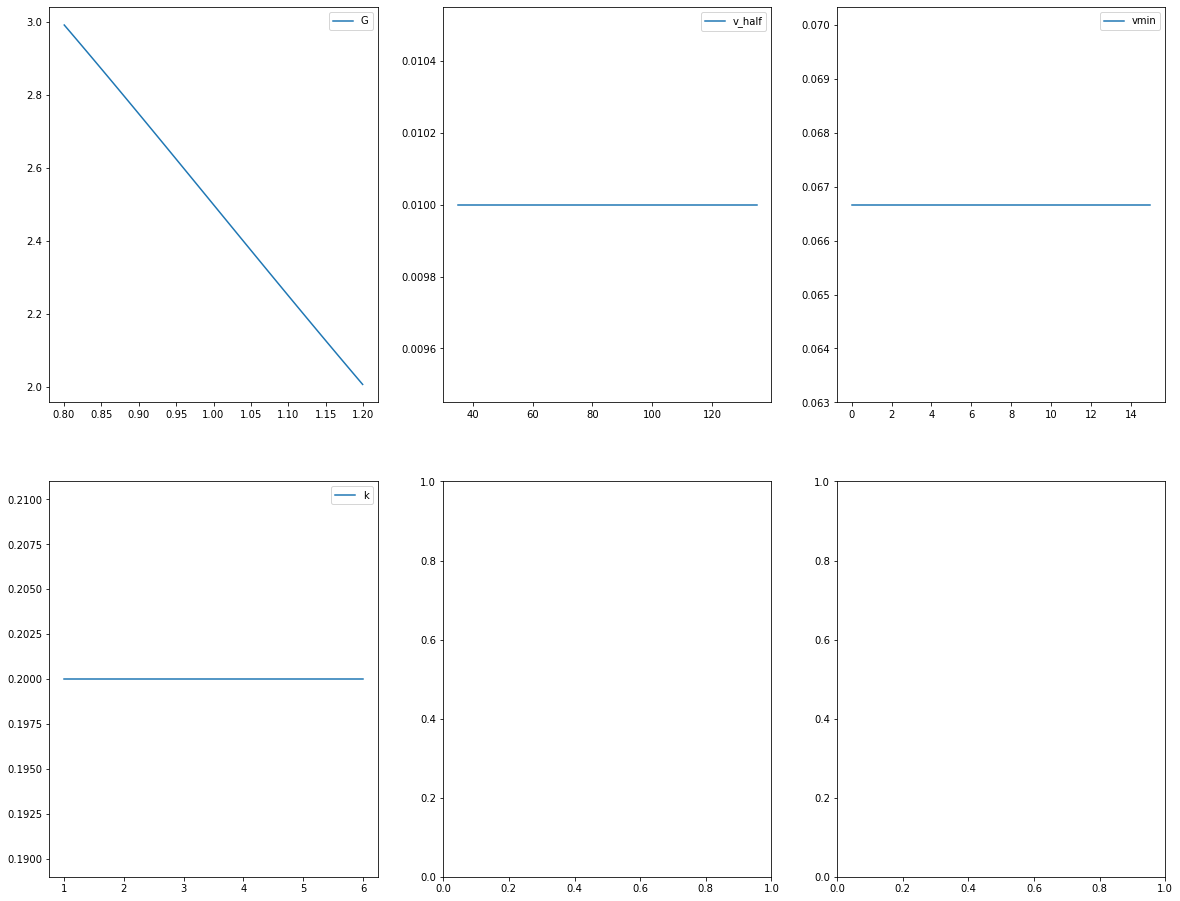

In [5]:
impf_unc.plot();

In [6]:
unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=100, sampling_method='saltelli', sampling_kwargs = {'calc_second_order': False})

2021-02-19 21:11:18,518 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 700


,x_exp,G,v_half,vmin,k
0,0.125521,0.832731,86.855469,10.151367,2.401367
1,0.833040,0.832731,86.855469,10.151367,2.401367
2,0.125521,0.815430,86.855469,10.151367,2.401367
3,0.125521,0.832731,124.941406,10.151367,2.401367
4,0.125521,0.832731,86.855469,7.514648,2.401367
...,...,...,...,...,...
695,0.326540,0.853179,91.494141,1.560059,5.855957
696,0.326540,1.015208,41.396484,1.560059,5.855957
697,0.326540,1.015208,91.494141,11.037598,5.855957
698,0.326540,1.015208,91.494141,1.560059,4.239746


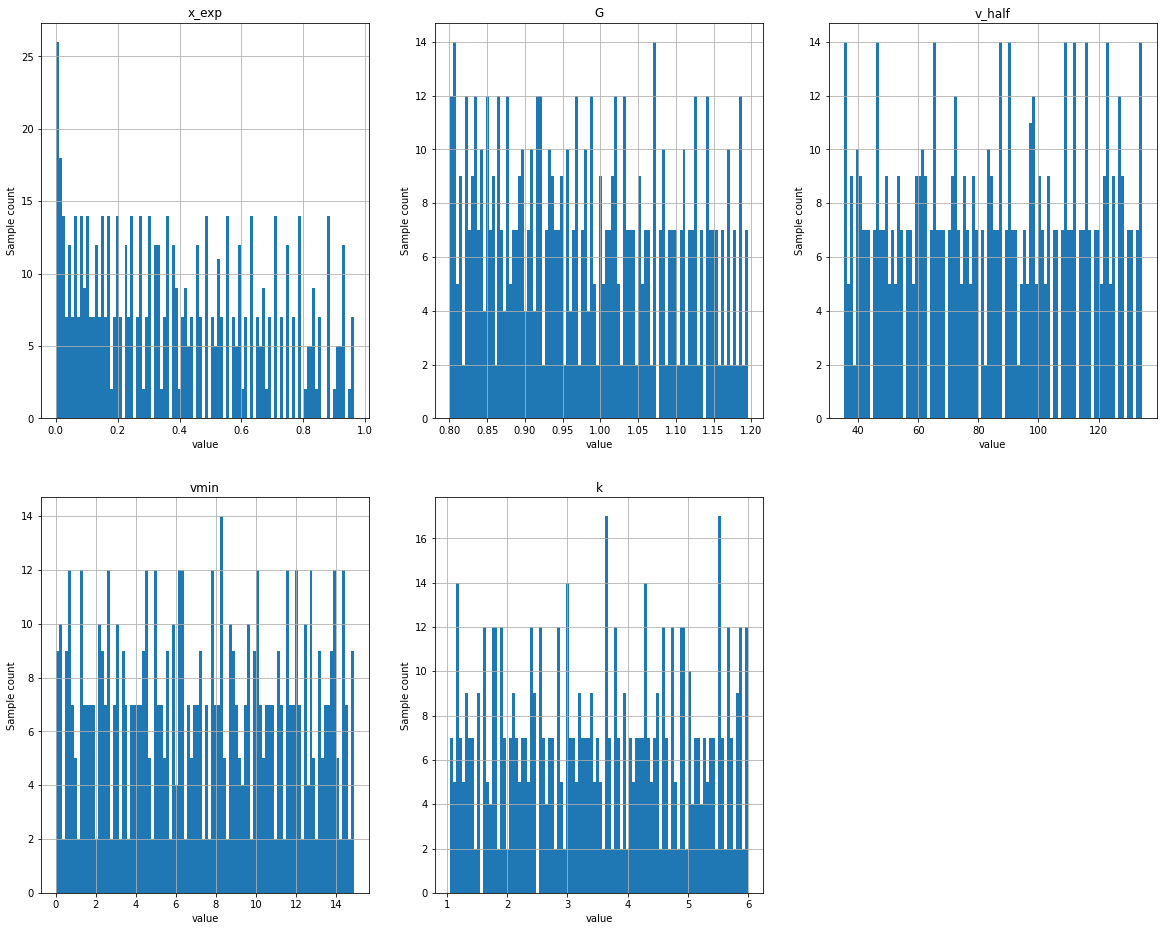

In [7]:
unc.plot_sample();

In [8]:
unc.calc_distribution(rp = [50, 100, 250])

2021-02-19 21:11:19,723 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-19 21:11:19,726 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-19 21:11:19,727 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-19 21:11:19,739 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:11:19,744 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 16.52s



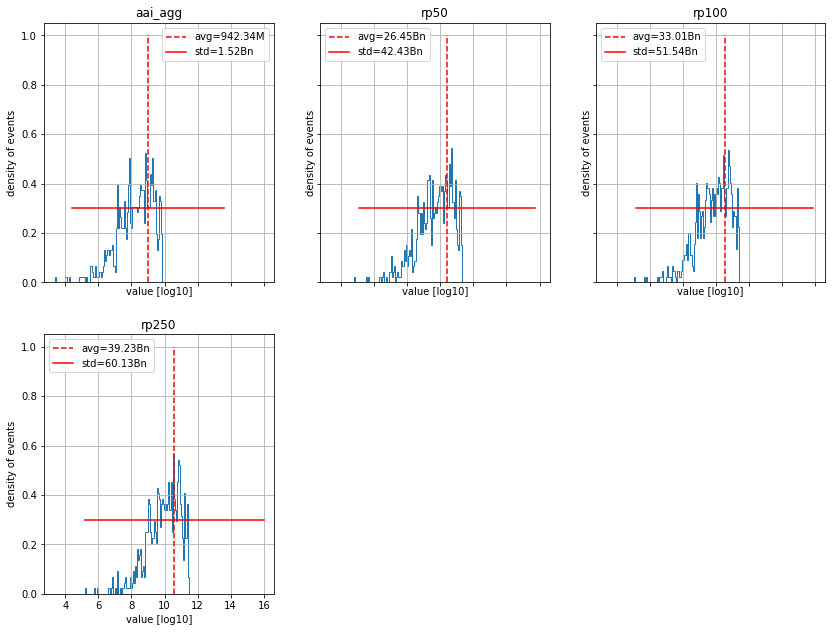

In [9]:
unc.plot_distribution(metric_list=['aai_agg', 'freq_curve']);

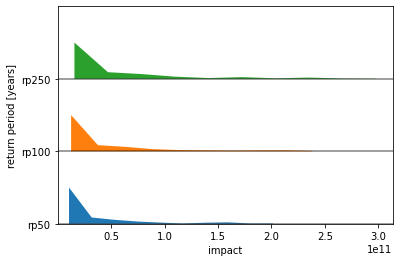

In [10]:
unc.plot_rp_distribution();

In [11]:
unc.calc_sensitivity(salib_method='sobol', method_kwargs = {'conf_level' : 0.95, 
                                                           'calc_second_order': False})

{'aai_agg': {'aai_agg': {'S1': array([0.35318387, 0.02888573, 0.29028966, 0.00244575, 0.07365607]),
   'S1_conf': array([0.17967496, 0.03722271, 0.1842082 , 0.0183128 , 0.12218573]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.21260106, 0.01486816, 0.33203942, 0.00759728, 0.16109677])}},
 'freq_curve': {'rp50': {'S1': array([0.35762565, 0.02671238, 0.30429953, 0.00039749, 0.07185341]),
   'S1_conf': array([0.16816982, 0.03498021, 0.20808252, 0.01826806, 0.12389276]),
   'ST': array([0.4598212 , 0.02464501, 0.61748473, 0.01009205, 0.23096831]),
   'ST_conf': array([0.21796735, 0.01627728, 0.34159533, 0.0063244 , 0.13129807])},
  'rp100': {'S1': array([3.68793718e-01, 2.63885339e-02, 3.39009260e-01, 2.81072504e-04,
          5.76714553e-02]),
   'S1_conf': array([0.17851762, 0.04297032, 0.23057382, 0.01573271, 0.09775241]),
   'ST': array([0.4745089 , 0.02347709, 0.71585254, 0.0063869 , 0.16279755]),
   'ST_conf': array([0.18736684

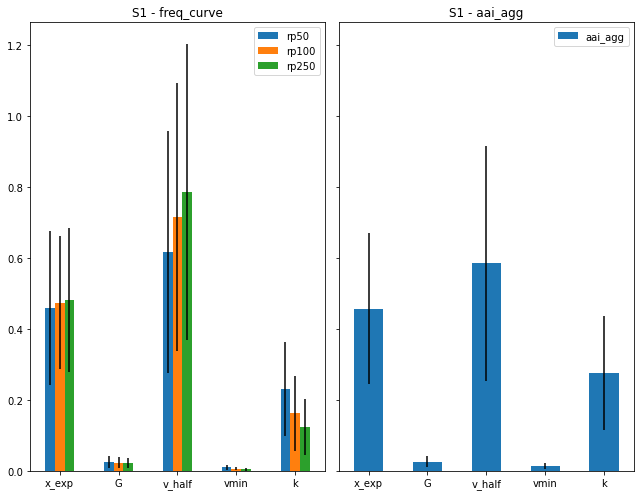

In [12]:
unc.plot_sensitivity();

## Cost Benefit 

In [13]:
def ent_today(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.value *= x_ent
    entity.check()
    return entity

def ent_future():
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040
    entity.check()
    return entity

def haz_fut_func(x_haz_fut, haz_base=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


In [14]:
haz = haz_base

haz_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_distr)

ent_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_unc = UncVar(ent_today, ent_distr)

ent_fut = ent_future()

2021-02-19 21:11:26,257 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-19 21:11:26,258 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-19 21:11:26,258 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-19 21:11:26,258 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-19 21:11:26,259 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-19 21:11:26,260 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-19 21:11:26,261 - climada.entity.exposures.base - INFO - geometry not set.


In [21]:
unc = UncCostBenefit(haz_unc=haz, ent_unc=ent_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut)
unc.make_sample(N=10, sampling_method='latin')
pool = Pool()
unc.calc_distribution(pool=pool)
pool.close()
pool.join()
pool.clear()

2021-02-19 21:12:28,080 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 10
2021-02-19 21:12:28,220 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-19 21:12:28,222 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-19 21:12:28,223 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-19 21:12:28,223 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-19 21:12:28,224 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-19 21:12:28,225 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-19 21:12:28,226 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-19 21:12:28,231 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-19 21:12:28,237 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 even

2021-02-19 21:12:28,585 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,585 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,586 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,587 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-19 21:12:28,590 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,590 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,591 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,591 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-19 21:12:28,599 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-19 21:12:28,598 - climada.engine.impact - INFO - Exposures matching cent

2021-02-19 21:12:28,720 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,722 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-19 21:12:28,723 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,724 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,725 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-19 21:12:28,727 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,726 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,728 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,728 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,731 - climada.

2021-02-19 21:12:28,826 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,827 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:28,827 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
--------------------  --------  --------
Total climate risk:   16.8477   (USD bn)
Average annual risk:   1.80917  (USD bn)
Residual risk:         1.47707  (USD bn)
--------------------  --------  --------2021-02-19 21:12:28,831 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,832 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,832 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,838 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-02-19 21:12:28,840 - climada.engin

--------------------  ---------  --------
2021-02-19 21:12:28,956 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-02-19 21:12:28,956 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Net Present Values2021-02-19 21:12:28,957 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


2021-02-19 21:12:28,960 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:28,964 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177            8.9367         6.81271
Beach nourishment          1.728              7.02297        4.06422
Seawall                    8.87878            0.733601       0.0826241
Building code              9.2               4

2021-02-19 21:12:29,155 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:29,158 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:29,158 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:29,163 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:29,163 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:29,165 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:29,165 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-19 21:12:29,170 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:29,171 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-19 21:12:29,173 - climada.en

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/ckropf/Documents/Climada/climada_python/climada/engine/uncertainty/base.py:535: RuntimeWarning: divide by zero encountered in log10
  ax.plot([np.log10(avg), np.log10(avg)], [0, 1],
/Users/ckropf/Documents/Climada/climada_python/climada/engine/uncertainty/base.py:538: RuntimeWarning: divide by zero encountered in log10
  ax.plot([np.log10(avg) - np.log10(std) / 2,
/Users/ckropf/Documents/Climada/climada_python/climada/engine/uncertainty/base.py:538: RuntimeWarning: invalid value encountered in double_scalars
  ax.plot([np.log10(avg) - np.log10(std) / 2,
/Users/ckropf/Documents/Climada/climada_python/climada/engine/uncertainty/base.py:539: RuntimeWarning: divide by zero encountered in log10
  np.log10(avg) + np.log10(std) / 2],
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib

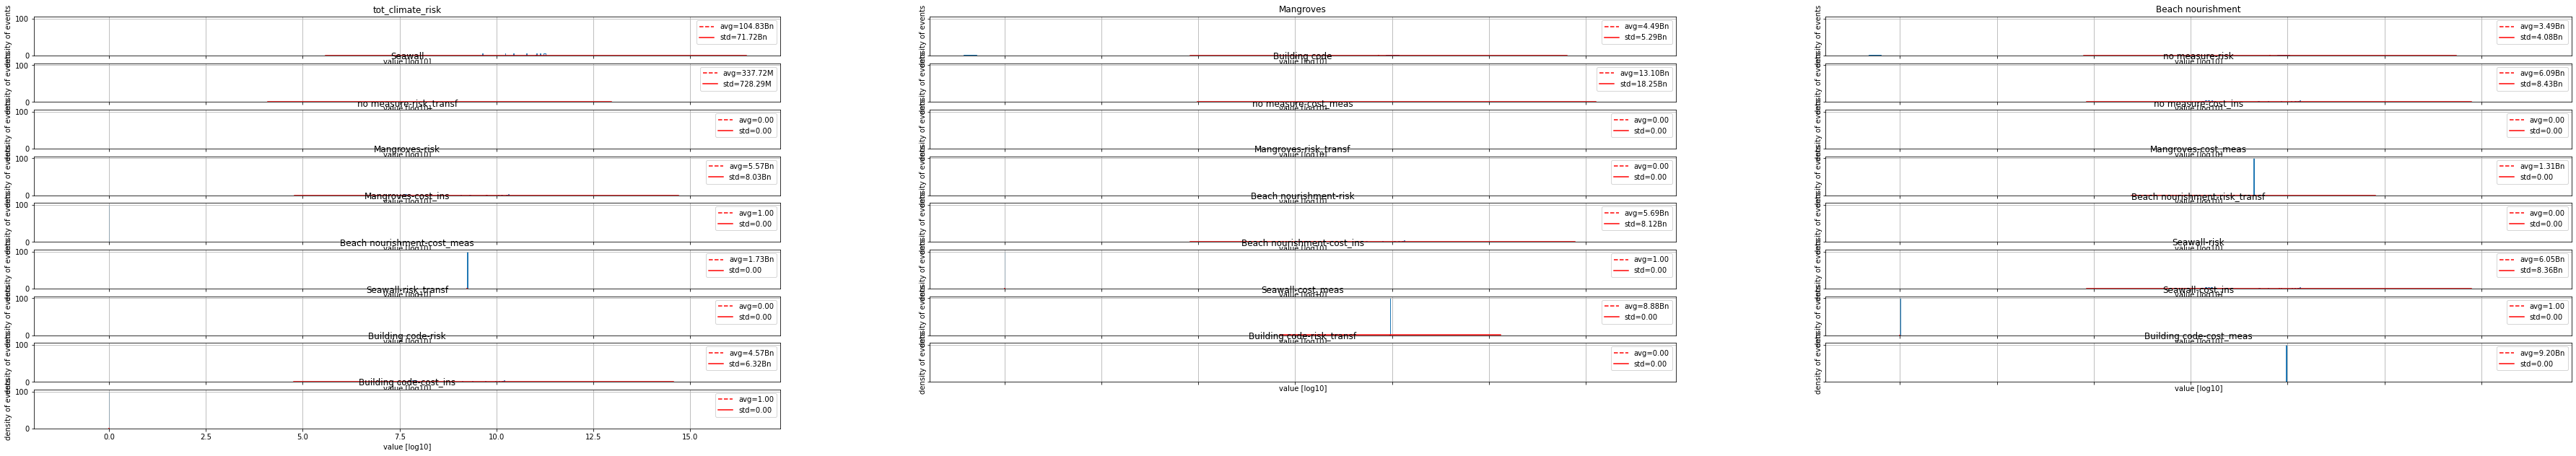

In [24]:
unc.plot_distribution();

In [18]:
unc.calc_sensitivity();

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib

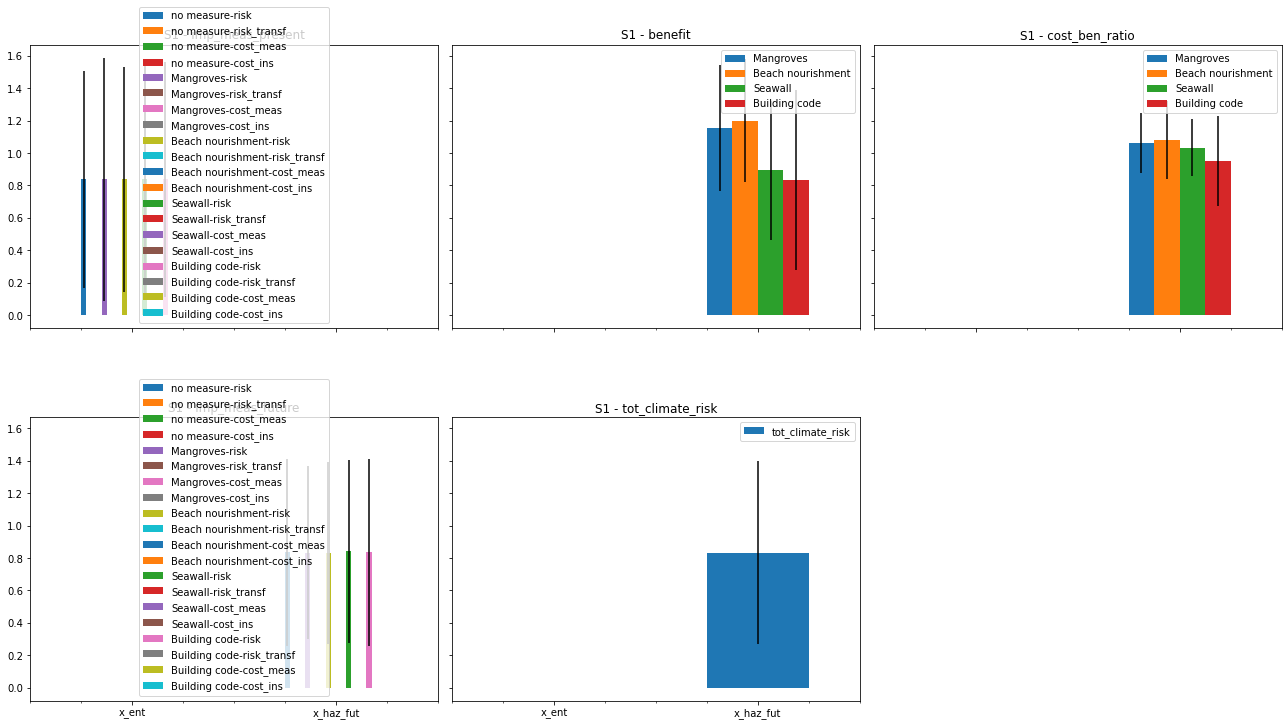

In [19]:
unc.plot_sensitivity();